In [55]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import math
import random
import os
import matplotlib.pyplot as plt
import parallel_plume_sim as pps
import multiprocessing
from figurefirst import FigureLayout,mpl_functions

##animating
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import plotly.graph_objects as go
import plotly.io as py

## training
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

In [59]:
puff_data_filename = '~/An/data/Sept13Plumes/plume4/puff_data_20230913_114503.pickle'

# how many seconds to include per chunk?
max_time = 2

# maximum distance in x and y to consider puffs before ignoring them?
min_x = -5
max_x = 20
min_y = -5
max_y = 20

pps.read_puff_data.split_puff_data_into_smaller_dataframes_and_cull_old_puffs(puff_data_filename, 
                                                                              max_time, 
                                                                              min_x, max_x, 
                                                                              min_y, max_y)

Directory /home/beast/An/data/Sept13Plumes/plume4/puff_data_20230913_114503 exists, contains 91 files.


Removed all files in:  /home/beast/An/data/Sept13Plumes/plume4/puff_data_20230913_114503


In [62]:
# This should match your directory name from above -- you need to change this
dirname = '/home/beast/An/data/Sept13Plumes/plume2/puff_data_20230913_113815'
# Class for reading puff data
puff_reader = pps.read_puff_data.PuffReader(dirname)

### Create a Trajectory

In [87]:
# n_points = 200 * 60  # 200Hz for 1 minute, change as needed
# step_size = 0.05  # meters

# steps = np.random.uniform(low=-step_size, high=step_size, size=(n_points, 2))
# points = np.cumsum(steps, axis=0)

# # Ensure the last point is (0,0) by shifting all points by the last point
# points -= points[-1]

# # Scale and shift the points to the desired range
# points[:, 0] = ((points[:, 0] - np.min(points[:, 0])) / (np.max(points[:, 0]) - np.min(points[:, 0])) * 5) + 5
# points[:, 1] = ((points[:, 1] - np.min(points[:, 1])) / (np.max(points[:, 1]) - np.min(points[:, 1])) * 13) + 2

# x = points[:,0]
# y = points[:,1]
# time = np.linspace(1,149,len(x))
# time = np.round(time, decimals=2)


In [88]:
# # Create a 10x10 grid
# f, ax = plt.subplots(figsize=(5,4))
# ax.grid(False)
# ax.scatter(x,y, s=1)
# # f.savefig('traject.jpg')

### Generate Trajectories and Collect Odor Encounters

In [93]:
def process_position(position):
    time, x, y = position
    concentration, wind_x, wind_y = puff_reader.get_odor_concentration_at_t_and_position(time, x, y)
    return concentration, wind_x, wind_y

def generate_trajectory(x_limits, y_limits, n_waypoints, noise_scale, n_eval_points):
    waypoints = np.zeros((n_waypoints, 2))
    
    # Using normal distribution for generating waypoints
    # waypoints[:, 0] = np.random.normal(loc=(x_limits[0] + x_limits[1]) / 2, scale=5, size=n_waypoints)
    # waypoints[:, 1] = np.random.normal(loc=(y_limits[0] + y_limits[1]) / 2, scale=5, size=n_waypoints)
    
    # ## diagonal trajectory
    # waypoints[:, 0] = np.linspace(x_limits[0], x_limits[1], n_waypoints)
    # waypoints[:, 1] = np.linspace(y_limits[0], y_limits[1], n_waypoints)
    
    ## random trajectory
    waypoints[:, 0] = np.random.uniform(x_limits[0], x_limits[1], n_waypoints)
    waypoints[:, 1] = np.random.uniform(y_limits[0], y_limits[1], n_waypoints)
    
    ## adding noise
    #waypoints += noise_scale * np.random.randn(n_waypoints, 2)  # Add noise

    # Adding more noise
    waypoints += 2* noise_scale * np.random.randn(n_waypoints, 2)
    
    # Randomizing the order of waypoints
    np.random.shuffle(waypoints)
    
    # Generate B-Spline as before
    tck, u = splprep(waypoints.T, s=0)
    unew = np.linspace(0, 1.0, n_eval_points)
    out = splev(unew, tck)

    return out[0], out[1]


def process_and_save_data(index,foldername):

    n_waypoints=math.floor(random.randint(90,200) / 10) * 10 #multiple of 10
    n_eval_points=math.floor(random.randint(1000,2000) / 50) * 50 #multiple of 50

    x, y = generate_trajectory((0,20),(0,20),n_waypoints,3.5,n_eval_points)
    time = np.linspace(1,99,len(x))
    # plt.plot(x,y)

    with multiprocessing.Pool() as pool:
        results = pool.map(process_position, [(time[i], x[i], y[i]) for i in range(len(x))])

    c = [result[0] for result in results]
    wx = [result[1] for result in results]
    wy = [result[2] for result in results]

    df_new = pd.DataFrame()
    df_new['odor'] = c
    df_new['windx'] = wx
    df_new['windy'] = wy
    df_new['x'] = x
    df_new['y'] = y
    # df_new['time']=time

    # filename = '~/DataAnalysis/data/generated_data_plume_sim/'+str(foldername)+'/diag{}.h5'.format(index)
    filename = '/home/beast/An/data/Sept13Plumes/plume2/'+str(foldername)+'/diag{}.h5'.format(index)
    df_new.to_hdf(filename, key='data', mode='w')


for i in range(1, 61):
    process_and_save_data(i,'train')


In [94]:

# Specify the directory you're working from
folder_path = '/home/beast/An/data/Sept13Plumes/plume2/train/'

# Get a list of all the .h5 files in the directory
files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]

# Initialize an empty dataframe
all_data = pd.DataFrame()

# Loop through the files and read each one into a dataframe
for file in files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_hdf(file_path)
    all_data = pd.concat([all_data, df])

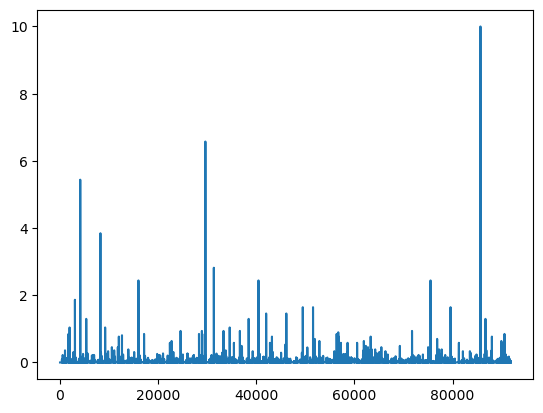

In [95]:
all_data=all_data.reset_index(drop=True)
df=pd.DataFrame()
df = all_data.copy()
plt.plot(scale_data(df.odor))

### Test stats

In [36]:
# Specify the directory you're working from
folder_path = '/home/beast/An/data/train_new_axis/'

# Get a list of all the .h5 files in the directory
files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]

# Initialize an empty dataframe
all_data = pd.DataFrame()

# Loop through the files and read each one into a dataframe
for file in files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_hdf(file_path)
    all_data = pd.concat([all_data, df])
    
all_data.reset_index(drop=True, inplace=True)

In [41]:
all_data['scaled_odor']=scale_data(all_data.odor)
query='scaled_odor>1'
df = all_data.query(query)
df.reset_index(drop=True, inplace=True)

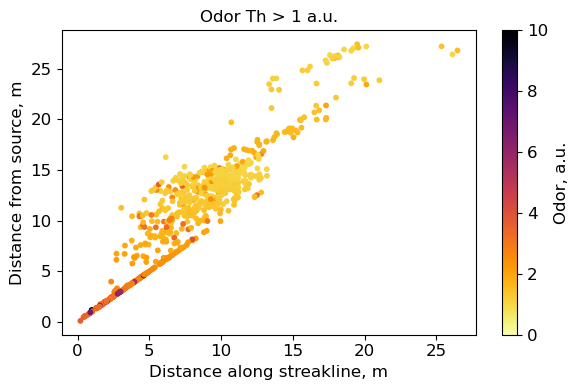

In [59]:
f,ax=plt.subplots(1,1,figsize=(6,4))
v=ax.scatter(df.distance_along_streakline, df.distance_from_source, c=df.scaled_odor, 
             s=10,
             cmap='inferno_r', vmin=0,vmax=10)
ax.set_title('Odor Th > 1 a.u.')
ax.set_ylabel('Distance from source, m')
ax.set_xlabel('Distance along streakline, m')
cbar = f.colorbar(v)
cbar.set_label('Odor, a.u.')  # Add label to colorbar
mpl_functions.set_fontsize(f, 12)
f.tight_layout()


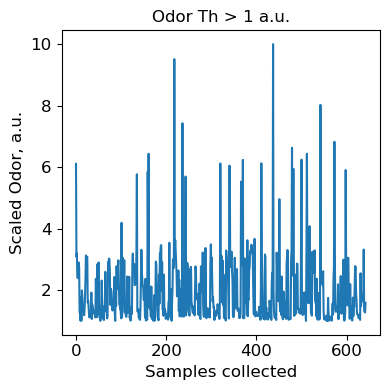

In [67]:
f,ax=plt.subplots(1,1,figsize=(4,4))
ax.plot(df.scaled_odor)
ax.set_title('Odor Th > 1 a.u.')
ax.set_ylabel('Scaled Odor, a.u.')
ax.set_xlabel('Samples collected')

mpl_functions.set_fontsize(f, 12)
f.tight_layout()